In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from argparse import Namespace

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from maskrcnn.postprocess.validate import L, gini, plot_scatter
from maskrcnn.postprocess.polygonize import load_anns

from scipy.spatial.distance import cdist
import rasterio
import rasterio.mask

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [3]:
def n_neighbor(coords, h):
    return (cdist(coords, coords, 'euclidean') < h).sum(axis=0).mean()

def diff(x):
    return np.max(x) - np.min(x)

In [4]:
# image index data
IDX_IN_DIR = 'data/Experiment3/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment3/aoi_download_log.csv'

# census data
CEN_IN_DIR = 'data/Experiment3/census.shp'

# satellite derived data
SAT_IN_ANN_DIR = 'data/MexicoInequality/Pred/infer/'
SAT_IN_IMG_DIR = 'data/MexicoInequality/Image/'
SAT_IN_SHP_DIR = 'data/Experiment3/sat.shp'
NL_IN_DIR = 'data/Nightlight/VIIRS_DNB_MX_2018.tif'

# output path
OUT_DIR = 'data/Experiment3/Output/'

In [5]:
dataset = rasterio.open(NL_IN_DIR)

In [6]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR), pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [7]:
assert (df_idx['status'] == False).sum() == 0  # no missing

In [8]:
# read census data
df_cen = gpd.read_file(CEN_IN_DIR)

In [9]:
nl_sums, nl_means = [], []
for geom in df_cen['geometry']:
    values, _ = rasterio.mask.mask(dataset, [geom], nodata=-1, crop=True)
    values = values[values >= 0] if (values >= 0).sum() > 0 else np.array([0])
    nl_sums.append(values.sum())
    nl_means.append(values.mean())
df_cen.loc[:, 'sat_nightlight_sum'] = nl_sums
df_cen.loc[:, 'sat_nightlight_mean'] = nl_means

In [10]:
if os.path.isfile(SAT_IN_SHP_DIR):
    df_sat = gpd.read_file(SAT_IN_SHP_DIR)
else:
    # read sat annotations
    ann_files = glob.glob(SAT_IN_ANN_DIR + '*.json')
    img_files = [os.path.join(SAT_IN_IMG_DIR,
                              (os.path.relpath(f, SAT_IN_ANN_DIR).replace('.json', '.png')))
                 for f in ann_files]
    df_sat = load_anns(ann_files=ann_files,
                       img_files=img_files,
                       idx_file=IDX_IN_DIR)
    df_sat = pd.merge(df_sat, df_idx, how='left', on='index')
    df_sat = df_sat.drop(columns=['RGB_mean', 'RGB_median'])

    df_sat = pd.merge(
        df_sat,
        (df_cen.loc[:, ['ent', 'mun', 'loc', 'geometry']]
         .rename({'geometry': 'geometry_loc'}, axis=1).drop_duplicates(['ent', 'mun', 'loc'])),
        how='left', on=['ent', 'mun', 'loc'])

    df_sat = df_sat.loc[df_sat['geometry'].within(gpd.GeoSeries(df_sat['geometry_loc'])), :]

    df_sat = df_sat.drop(columns=['geometry_loc'])

    df_sat.to_file(SAT_IN_SHP_DIR, index=False)

In [11]:
df_sat = df_sat.sort_values(by=['ent', 'mun', 'loc', 'index'])

In [12]:
# this doesn't prove to be very useful
# df_sat.loc[:, 'redness_l'] = df_sat['R_mean'] / df_sat['luminosity']

In [13]:
rgb = df_sat.loc[:, ['R_median', 'G_median', 'B_median']].values

pca = PCA(n_components=3)
rgb_reproj = pca.fit_transform(rgb - rgb.mean(axis=0)[np.newaxis, :])
df_sat.loc[:, 'sat_color_pca0'] = rgb_reproj[:, 0]
df_sat.loc[:, 'sat_color_pca1'] = rgb_reproj[:, 1]
df_sat.loc[:, 'sat_color_pca2'] = rgb_reproj[:, 2]
print(pca.explained_variance_ratio_)

# here I tried K means clustering quickly
# and it doesn't seem to work in separating red versus other colors
# I think it's a bit too random and depends heavily on data distribution
# we should use something more deterministic

# n_clusters = 2
# km = KMeans(
#     n_clusters=n_clusters,
#     random_state=6,
# )
# y = km.fit_predict(rgb)

# rgb_reproj = np.hstack([rgb_reproj, rgb / 255, y[:, np.newaxis]])

# rgb_idx = np.random.randint(rgb_reproj.shape[0], size=500)
# rgb_reproj = rgb_reproj[rgb_idx, :]

# fig, ax = plt.subplots(nrows=n_clusters)
# for i in range(n_clusters):
#     for row in rgb_reproj[rgb_reproj[:, -1] == i, :]:
#         ax[i].scatter(row[0], row[1], color=(row[-4], row[-3], row[-2]))
# plt.show()

[0.94621753 0.0494445  0.00433797]


In [14]:
# grouping into localities
df_group = df_sat.drop(columns=['geometry']).groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='area', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
#     sat_size_med=pd.NamedAgg(column='area', aggfunc=np.nanmedian),  # nah not better than mean
    sat_lum_mean=pd.NamedAgg(column='luminosity', aggfunc=np.nanmean),
    sat_saturation_mean=pd.NamedAgg(column='saturation', aggfunc=np.nanmean),
    sat_redness_mean=pd.NamedAgg(column='redness', aggfunc=np.nanmean),
    sat_color_pca0_mean=pd.NamedAgg(column='sat_color_pca0', aggfunc=np.nanmean),
    sat_color_pca1_mean=pd.NamedAgg(column='sat_color_pca1', aggfunc=np.nanmean),
    sat_color_pca2_mean=pd.NamedAgg(column='sat_color_pca2', aggfunc=np.nanmean),
#     sat_size_gini=pd.NamedAgg(column='area', aggfunc=gini_series),  # no signal
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)
)

# measure spatial clustering
tile_size = 1.6516e-3

for i, col in zip([.05, .1, .2, .3, .53],
                  ['sat_nn_h05', 'sat_nn_h10', 'sat_nn_h20', 'sat_nn_h30', 'sat_nn_h53']):
    df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
        lambda grp: n_neighbor(
            np.array([grp.centroid.x.values, grp.centroid.y.values]).T,
            h=tile_size * i))

# calculate K function values
# tile_size = 1.6516e-3
# for i, col in zip([.5, 1, 1.5],
#                   ['sat_dist_h05', 'sat_dist_h10', 'sat_dist_h15']):
#     df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
#         lambda grp: L(grp[['lon_center', 'lat_center']].values,
#                       A=(tile_size ** 2) * 25, h=tile_size * i))

# scale areas / distances
df_group[['sat_size_mean', 'sat_size_sum']] *= (
    ((tile_size / 800 * 111000) ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters

df_group['sat_angle_align'] = df_sat.groupby(['ent', 'mun', 'loc', 'index']).apply(
    lambda grp: np.sort(np.histogram(
        grp['angle'].values,
        bins=9, range=(0, 90), density=True)[0] * 10)[-2:].sum()).groupby(['ent', 'mun', 'loc']).agg('mean')

In [15]:
for q in [80, 85, 90, 95]:
    print(q, np.percentile(df_sat['redness'], q))
    df_sat.loc[:, 'redness_q{}'.format(q)] = df_sat['redness'] > np.percentile(df_sat['redness'], q)
    df_group.loc[:, 'sat_redness_q{}'.format(q)] = df_sat.groupby(['ent', 'mun', 'loc']).agg({
        'redness_q{}'.format(q): 'mean'}).values
# for q in [80, 85, 90, 95]:
#     print(q, np.percentile(df_sat['redness_l'], q))
#     df_sat.loc[:, 'redness_l_q{}'.format(q)] = df_sat['redness_l'] > np.percentile(df_sat['redness_l'], q)
#     df_group.loc[:, 'sat_redness_l_q{}'.format(q)] = df_sat.groupby(['ent', 'mun', 'loc']).agg({
#         'redness_l_q{}'.format(q): 'mean'}).values

80 18.0
85 28.0
90 39.5
95 56.0


In [16]:
# merge satellite and census
df_group = pd.merge(
    df_group,
    df_cen,
    how='right', on=['ent', 'mun', 'loc'])

In [17]:
df_group['rich'] = (df_group['diff'] > 0)

In [18]:
# plot_scatter(
#     col_x_key='VIVTOT',
#     col_x_label='VIVTOT',
#     transform_x=lambda x: np.log10(x + 1),
#     col_y_key='sat_house',
#     col_y_label='sat_house',
#     transform_y=lambda x: np.log10(x + 1),
#     line=True, df=df_group.loc[df_group['POBTOT'] > 10, :],
#     out_dir=os.path.join(OUT_DIR, 'all'), show=True)

In [19]:
# for var in ['sat_redness_mean', 'sat_size_mean',
#             'sat_angle_align']:
#     plot_scatter(
#         col_x_key='cen_asset',
#         col_x_label='Census: Asset Score (PCA 1st Dimension)',
#         col_y_key=var,
#         col_y_label=var,
#         line=True, df=df_group.loc[df_group['POBTOT'] > 10, :],
#         out_dir=os.path.join(OUT_DIR, 'all'), show=True)

In [20]:
sat_cols = [col for col in df_group.columns if col.startswith('sat')]

In [21]:
df_group = df_group.pivot(index='pair_id', columns='rich', values=['diff'] + sat_cols + ['POBTOT'])

In [22]:
# who is this guy creating all these outliers???
# it is just one locality (with 9 people!) who is super rich
# matched with three localities, creating three pairs
# df_group.loc[df_group[('diff', True)] > 1.5, :]
# df_cen.loc[df_cen['pair_id'].isin([170, 221, 233]), :]
# this is crazy and totally screwing everything up
# I'm dropping localities with <10 people
df_group = df_group.loc[
    (df_group.loc[:, ('POBTOT', True)] > 10) & (df_group.loc[:, ('POBTOT', False)] > 10), :]

In [23]:
# for var in sat_cols:
#     fig, ax = plt.subplots(figsize=(15, 5))
#     # for v in (True, False):
#     #     ax.scatter(df_group.loc[:, ('diff', True)], df_group.loc[:, (var, v)], color='k')
#     for _, row in df_group.iterrows():
#         ax.plot([row[('diff', True)]] * 2, [row[(var, True)], row[(var, False)]],
#                 color='r' if row[(var, True)] > row[(var, False)] else 'b')
#     ax.set_ylabel(var)
#     plt.savefig(os.path.join(OUT_DIR, 'all/{}_line.pdf'.format(var)))

In [24]:
df_diff = pd.DataFrame({'asset_diff': df_group.loc[:, ('diff', True)]})

for var in sat_cols:
    df_diff.loc[:, var + '_diff'] = df_group.loc[:, (var, True)] - df_group.loc[:, (var, False)]

In [25]:
model = smf.ols('asset_diff ~ sat_color_pca0_mean_diff + '
                'sat_color_pca1_mean_diff + sat_color_pca2_mean_diff', data=df_diff)
res = model.fit()
df_diff.loc[:, 'sat_color_pca_pred_diff'] = res.fittedvalues

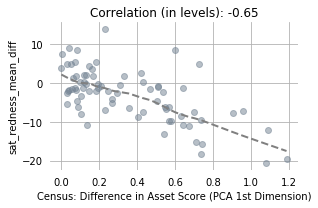

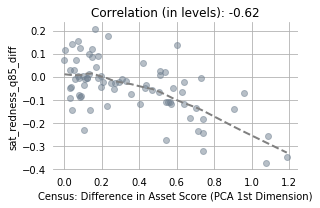

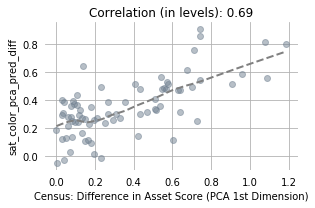

In [26]:
for var in [
#         'sat_redness_l_mean',
#         'sat_redness_l_q80', 'sat_redness_l_q85',
#         'sat_redness_l_q90', 'sat_redness_l_q95',
#     'sat_color_pca0_mean', 'sat_color_pca1_mean', 'sat_color_pca2_mean',
        'sat_redness_mean', 'sat_redness_q85', 'sat_color_pca_pred']:
    plot_scatter(
        col_x_key='asset_diff',
        col_x_label='Census: Difference in Asset Score (PCA 1st Dimension)',
        col_y_key=var + '_diff',
        col_y_label=var + '_diff',
        line=True, frac=0.5, df=df_diff,
        out_dir=os.path.join(OUT_DIR, 'all'), show=True)

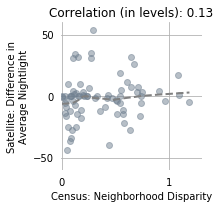

In [27]:
plot_scatter(
    col_x_key='asset_diff',
    col_x_label='Census: Neighborhood Disparity',
    xlim=(-0.01, 1.3),
    xticks=[0, 1],
    col_y_key='sat_nightlight_mean_diff',
    col_y_label='Satellite: Difference in\nAverage Nightlight',
    ylim=(-60, 60),
    yticks=[-50, 0, 50],
    line=True, frac=0.5, df=df_diff,
    figsize=(3, 3),
    out_dir=OUT_DIR, show=True)

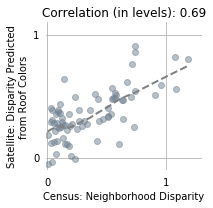

In [28]:
plot_scatter(
    col_x_key='asset_diff',
    col_x_label='Census: Neighborhood Disparity',
    xlim=(-0.01, 1.3),
    xticks=[0, 1],
    col_y_key='sat_color_pca_pred_diff',
    col_y_label='Satellite: Disparity Predicted\nfrom Roof Colors',
    ylim=(-0.1, 1.1),
    yticks=[0, 1],
    line=True, frac=0.5, df=df_diff,
    figsize=(3, 3),
    out_dir=OUT_DIR, show=True)